# Домашняя работа 3: Разработка модели детектирования объектов

##  Файзуллов Айрат Рафагатович

На семинаре мы обсудили, разработали и попробовали `SSD` модель на базе `VGG16`, поэтому для успешного выполнения домашнего задания рекомендуется обратиться к семинару.

Задачи домашнего задания:
 - Загрузить набор данных и визуализировать объекты. (2 балла)
 - Разработать функцию для расчета метрики mAP задачи детектирования объектов. Продемонстрировать работу. (4 балла)
 - Натренировать `SSD` модель на базе VGG16. Продемонстрировать повышение метрики mAP (4 балла)
 - Разработать `SSD` модель согласно предлагаемой архитектуры на базе `ResNet18`. Продемонстрировать повышение метрики mAP (10 баллов)
 - (БОНУС) Добавить разнообразные аугментации изображений. Можно позаимствовать из других репозитариев с указанием источника. Повторить эксперименты (5 баллов)

## Описание предлагаемых исходных кодов
- voc_dataset.py     - загружает предлагаемый набор данных, здесь также возможно выполнять аугментации над данными.
- voc_dataloader.py  - формирует порцию данных.
- prior_boxes.py     - содержит все необходимые функции для работы с `prior` боксами.
    - prior_boxes - функция генерирует `prior` боксы в соотвествии с конфигурацией
    - match       - функция решает задачу сопоставления `ground truth` боксов из набора данных и `prior` боксов
    - decode      - функция вычисляет поправки между `ground truth` боксами и `prior` боксами, собственно их будет *предсказывать* наша модель
    - encode      - функция пересчитывает `prior` боксы и *предсказанные* поправки в результирующие детектирования

- model_vgg16.py   - реализация `SSD` на базе VGG16, которая рассматривалась на семинаре.
- multibox_loss.py - комплексная функция потерь, решается задача сопоставления *предсказанных* и `ground truth` боксов, применяется техника `hard-negative mining`, вычисляется общая функция потерь.

- train_model.py    - пример, который тренирует модель детектирования.
- evaluate_model.py - пример, который визуализирует результат работы модели детектирования.

## Архитектура модели на основе VGG16

Обязательно посмотрите реализацию и разберитесь в том, как устроенна модель, это будет полезно при разработке собственной модели детектирования.

![Image](output_vgg16.png)

## Архитектура модели на основе ResNet18

Можно исследовать реализацию ResNet в пакете PyTorch, это будет полезно при разработке собственного детектора.

https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

![Image](output_resnet18.png)

In [1]:
root_dir = "drive/MyDrive/HW3_ObjectDetection/"

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!tar -xzvf $root_dir/dataset_gs198-05.tar.gz -C $root_dir > /dev/null

In [4]:
!ls $root_dir

#root_dir = "drive/MyDrive/HW3_ObjectDetection"2

!cp  $root_dir/train_model.py      .
!cp  $root_dir/evaluate_model.py   .
!cp  $root_dir/model_vgg16.py      .
!cp  $root_dir/voc_dataloader.py  root_dir = "drive/MyDrive/HW3_ObjectDetection/" .
!cp  $root_dir/multibox_loss.py    .
!cp  $root_dir/prior_boxes.py      .
!cp  $root_dir/voc_dataset.py      .

dataset			 model_vgg16.py       output_vgg16.png	voc_dataloader.py
dataset_gs198-05.tar.gz  multibox_loss.py     prior_boxes.py	voc_dataset.py
evaluate_model.py	 output_resnet18.png  train_model.py
cp: cannot stat 'root_dir': No such file or directory
cp: cannot stat '=': No such file or directory
cp: -r not specified; omitting directory 'drive/MyDrive/HW3_ObjectDetection/'


In [5]:
!pip install torchview

## Создаем конфигурацию, которая описывает работы нашего детектора (пример для VGG16)

In [6]:
#VGG16
custom_config = {
 'num_classes'  : 3,
 'feature_maps' : [(90,160), (45,80), (23,40), (12,20), (10,18), (8,16)], #Размерность карт признаков, которые будут использоваться
 'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
 'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],

 'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]], #Список содержаший информацию о соотношении сторон для prior боксов
 'num_priors'   : [6, 6, 6, 6, 4, 4], #Число prior боксов
 'variance'     : [0.1, 0.2],
 'clip'         :    True,

 'overlap_threshold': 0.5, #Параметр IoU
 'neg_pos_ratio'    :   3, #Параметр hard-negative mining

 'model_name' : 'vgg16'
}


## Загружаем требуемый набор данных

In [7]:
from torchvision        import transforms
import numpy as np

transform = transforms.Compose([transforms.ToTensor()])

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

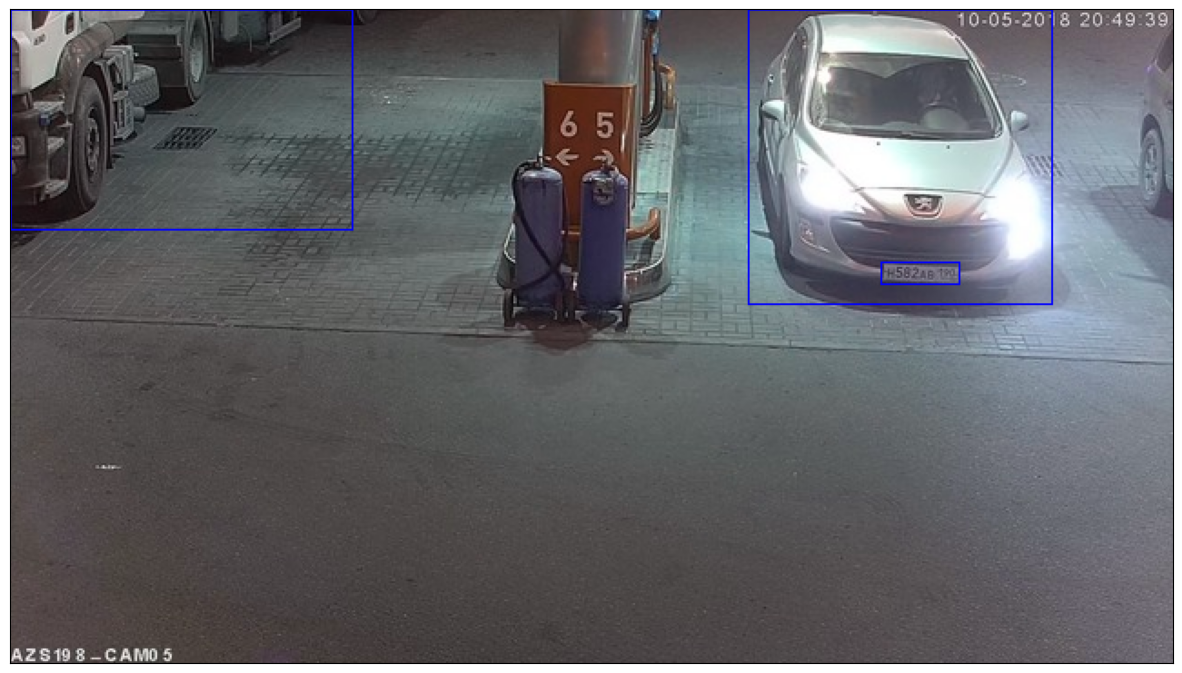

In [8]:
from torchvision.transforms.functional import convert_image_dtype
from torchvision.utils import draw_bounding_boxes
from matplotlib import pyplot as plt
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import torch
from random import randint
from voc_dataset import VOCDetection
import os


dataset_root_dir = 'drive/MyDrive/HW3_ObjectDetection/dataset'
train_annotation_filename = os.path.join(dataset_root_dir, "ImageSets/Main/trainval.txt")

train_dataset = VOCDetection(dataset_root_dir, train_annotation_filename)
i = randint(0, 20)
a ,b ,c = train_dataset[i]

normalize_back = Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

_, height, width = a.shape
b[:, 0::2] = b[:, 0::2] * width                                   #beacuse not full hd
b[:, 1::2] = b[:, 1::2] * height

result_colors = ["blue"]*b.shape[0]

back_transformed_image = normalize_back(a.permute(0, 1, 2))

result = draw_bounding_boxes(convert_image_dtype(back_transformed_image, dtype=torch.uint8), b, colors=result_colors, width=1)
show(result)

## Разработать функцию вычисление mAP метрики задачи детектирования

In [117]:
import numpy as np
from prior_boxes import  match
from prior_boxes import  jaccard

def count_pr_rec(tbl):
  if tbl.shape[0] > 30:
    tbl = tbl[:30]

  if torch.sum(tbl[:, 1]) == 0:
    prec = np.zeros(tbl.shape[0])
    rec = np.ones(tbl.shape[0])
    s = 0
  else:

    recall = torch.sum(tbl[:, 1]).item()
    sum_true = 0
    prec = np.array([])
    rec = np.array([])
    all_obj = 0
    for i in tbl:
      z = i[1].item()
      all_obj += 1
      sum_true += z
      if sum_true == 0:
        prec = np.append(prec, 0)
      else:
        prec = np.append(prec, sum_true/all_obj)
      rec = np.append(rec, sum_true/recall)

    max_i = 0
    prev_x = rec[tbl.shape[0] - 1]
    s = 0
    for i in range(tbl.shape[0] - 1, -1, -1):
      x = -(rec[i] - prev_x)
      prev_x = rec[i]
      s = max_i * x + s
      if prec[i] > max_i:
        max_i = prec[i]
  return s


def count_map(threshold, loader):

  full_array_matr = []
  for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(loader):
    image_s_gpu = image_s_cpu.cuda()
    label_ss_gpu = [label_s_cpu.cuda() for label_s_cpu in label_ss_cpu]
    box_ss_gpu = [box_s_cpu.cuda() for box_s_cpu in box_ss_cpu]

    pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)

    batch_size = pred_loc_ss_gpu.shape[0]

    arr_matrix = []
    for i in range(batch_size):
      jac_true_pred = jaccard(box_ss_gpu[i], pred_loc_ss_gpu[i])                                          # нашли пересечения true and predicted
      max_jacc = jac_true_pred[torch.arange(box_ss_gpu[i].size(0)), torch.argmax(jac_true_pred, dim=1)]   # in every row find best predicted box
      indices = torch.nonzero(max_jacc > threshold).squeeze()                                             # find rows with jacc higher than threshold
      indices_pred_best = torch.argmax(jac_true_pred, dim=1)[indices]                                     # NMS

      best_class_pred = pred_conf_ss_gpu[i][:][indices_pred_best]
      if best_class_pred.dim() == 2:
        best_class_pred[:, 0] = -10000
        f_cl = best_class_pred[:, 1] > best_class_pred[:, 0]
        s_cl = best_class_pred[:, 2] > best_class_pred[:, 0]
      if best_class_pred.dim() == 1:
        best_class_pred[0] = -10000
        f_cl = best_class_pred[1] > best_class_pred[0]
        s_cl = best_class_pred[2] > best_class_pred[0]

      best_class_pred = torch.argmax(best_class_pred, dim=-1) + 1   # get tensor of 1, 2
      true_class = label_ss_gpu[i][indices]

      tensor1 = true_class.clone().detach()
      tensor2 = (true_class == best_class_pred).clone().detach()
      tensor3 = max_jacc[indices].clone().detach()
      matrix = torch.cat((tensor1.unsqueeze(0), tensor2.unsqueeze(0), tensor3.unsqueeze(0)), dim=0).T   # Получаем матрицу: первый столбец - класс, 2 - T/F, 3 - score
      arr_matrix.append(matrix)
    non_empty_tensors = [tensor.unsqueeze(0) if len(tensor.shape) == 1 else tensor for tensor in arr_matrix if tensor.numel() > 0]
    if len(non_empty_tensors) == 0:
      continue
    else:
      result_tensor = torch.cat(non_empty_tensors, dim=0)
      full_array_matr.append(result_tensor)

  non_empty_tensors = [tensor.unsqueeze(0) if len(tensor.shape) == 1 else tensor for tensor in full_array_matr if tensor.numel() > 0]
  if len(non_empty_tensors) == 0:
    return 0
  result_tensor = torch.cat(non_empty_tensors, dim=0)

  selected_cars = result_tensor[result_tensor[:, 0] == 2]
  sorted_indices_cars = torch.argsort(-selected_cars[:, 2])
  sorted_tensor_cars = selected_cars[sorted_indices_cars]
  ap_cars = count_pr_rec(sorted_tensor_cars)

  selected_table = result_tensor[result_tensor[:, 0] == 1]
  sorted_indices_table = torch.argsort(-selected_table[:, 2])
  sorted_tensor_table = selected_table[sorted_indices_table]
  ap_table = count_pr_rec(sorted_tensor_table)

  return (ap_table + ap_cars)/2

## Натренировать модель на основе VGG16

In [19]:
from torch.optim.lr_scheduler import MultiStepLR

import numpy as np

import argparse
import timeit
import torch
import time
import os

from voc_dataloader  import get_train_dataloader, get_test_dataloader

#from model_resnet18  import SSD_ResNet18
from model_vgg16     import SSD_VGG16
from multibox_loss   import MultiBoxLoss
from prior_boxes     import prior_boxes

from tqdm import tqdm


def make_parser():
    parser = argparse.ArgumentParser(description="Train Single Shot MultiBox Detector on custom dataset")
    parser.add_argument('--dataset_root_dir', type=str, default='dataset')
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--checkpoint', type=str, default=None)
    parser.add_argument('--output', type=str, default='output')
    parser.add_argument('--multistep' , nargs='*', type=int, default=[20, 40, 60])
    parser.add_argument('--learning_rate', type=float, default=1e-3)
    parser.add_argument('--momentum', type=float, default=0.9)
    parser.add_argument('--weight-decay', type=float, default=0.0005)
    parser.add_argument('--warmup', type=int, default=None)
    parser.add_argument('--num-workers', type=int, default=4)

    parser.add_argument('--seed', type=int, default=42)

    return parser

if __name__ == "__main__":
    parser = make_parser()
    #args = parser.parse_args(['--dataset_root_dir', root_dir + '/dataset'])
    args = parser.parse_args(['--dataset_root_dir', 'drive/MyDrive/HW3_ObjectDetection/dataset'])

    os.makedirs('./models', exist_ok=True)

    log_interval = 20
    json_summary = 'output.json'

    torch.manual_seed(args.seed)   # for random nums generators
    np.random.seed(seed=args.seed)

    dataset_root_dir = args.dataset_root_dir
    train_annotation_filename = os.path.join(dataset_root_dir, "ImageSets/Main/trainval.txt")
    test_annotation_filename = os.path.join(dataset_root_dir, "ImageSets/Main/test.txt")
    train_dataloader = get_train_dataloader(dataset_root_dir, train_annotation_filename, args.batch_size, args.num_workers)
    test_dataloader = get_test_dataloader (dataset_root_dir, test_annotation_filename , args.batch_size, args.num_workers)

    learning_rate = args.learning_rate

    if not os.path.exists(args.output):
        os.mkdir(args.output)

    custom_config = {
     'num_classes': 3,
     #'feature_maps' : [(90,160), (45,80), (23,40), (12,20), (10,18), (8,16)], #VGG16 - 1280x720
     'feature_maps': [(45,80), (22,40), (11,20), (6,10), (4,8), (2,6)], #VGG16 - 640x360

     'min_sizes': [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
     'max_sizes': [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],

     'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
     'num_priors': [6, 6, 6, 6, 4, 4],
     'variance': [0.1, 0.2],
     'clip':    True,

     'overlap_threshold': 0.5,
     'neg_pos_ratio': 3,

     'model_name': 'vgg16'
    }

    model = SSD_VGG16(custom_config['num_priors'], custom_config['num_classes'])

    prior_box_s = prior_boxes(custom_config)
    prior_box_s_gpu = prior_box_s.cuda()

    overlap_threshold = custom_config['overlap_threshold']
    neg_pos_ratio = custom_config['neg_pos_ratio']
    variance = custom_config['variance']

    criterion = MultiBoxLoss(overlap_threshold, neg_pos_ratio, variance)
    model.cuda()
    criterion.cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, momentum=args.momentum, weight_decay=args.weight_decay )
    scheduler = MultiStepLR(optimizer=optimizer, milestones=args.multistep, gamma=0.2)

    best_loc_loss, best_cls_loss, best_loss = np.inf, np.inf, np.inf
    for epoch in tqdm(list(range(args.epochs))):
        #Train model
        train_loc_loss, train_cls_loss, train_loss = 0, 0, 0
        model.train()
        for i, (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(train_dataloader):
            start = timeit.default_timer()
            image_s_gpu = image_s_cpu.cuda()
            label_ss_gpu = [label_s_cpu.cuda() for label_s_cpu in label_ss_cpu]

            box_ss_gpu = [box_s_cpu.cuda() for box_s_cpu in box_ss_cpu]


            pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)

            loc_loss, cls_loss = criterion((pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))
            loss = loc_loss + cls_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loc_loss += loc_loss.item()
            train_cls_loss += cls_loss.item()
            train_loss     += loss    .item()
            stop = timeit.default_timer()
            #print('Time: ', stop - start)
        scheduler.step()
        #Eval model
        eval_loc_loss, eval_cls_loss, eval_loss = 0, 0, 0
        model.eval()
        for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(test_dataloader):
            image_s_gpu = image_s_cpu.cuda()
            label_ss_gpu = [label_s_cpu.cuda() for label_s_cpu in label_ss_cpu]
            box_ss_gpu = [box_s_cpu.cuda() for box_s_cpu in box_ss_cpu]

            pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)

            loc_loss, cls_loss = criterion((pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))
            loss = loc_loss + cls_loss

            eval_loc_loss += loc_loss.item()
            eval_cls_loss += cls_loss.item()
            eval_loss += loss.item()

        test_map = count_map(0.5, test_dataloader)
        print('epoch[{}] | lr {:.5f} | loc_loss [{:.2f}/{:.2f}] | cls_loss [{:.2f}/{:.2f}] | total_loss [{:.2f}/{:.2f}]'.format(epoch, scheduler.get_last_lr()[0], train_loc_loss, eval_loc_loss, train_cls_loss, eval_cls_loss, train_loss, eval_loss))
        print("TEST_MAP:" + str(test_map))
        if eval_loss < best_loss :
            torch.save(model.state_dict(), os.path.join(args.output, f"{custom_config['model_name']}.pth"))
            best_loc_loss, best_cls_loss, best_loss = eval_loc_loss, eval_cls_loss, eval_loss

  0%|          | 0/50 [00:00<?, ?it/s]

epoch[0] | lr 0.00100 | loc_loss [436.40/10.14] | cls_loss [878.88/22.70] | total_loss [1315.29/32.84]
TEST_MAP:0.04171209024277406


  2%|▏         | 1/50 [02:21<1:55:25, 141.34s/it]

epoch[1] | lr 0.00100 | loc_loss [196.78/7.73] | cls_loss [458.47/18.82] | total_loss [655.25/26.54]
TEST_MAP:0.03550209528907576


  4%|▍         | 2/50 [04:43<1:53:19, 141.65s/it]

epoch[2] | lr 0.00100 | loc_loss [158.62/6.41] | cls_loss [406.20/18.17] | total_loss [564.82/24.58]
TEST_MAP:0.04778898742869563


  8%|▊         | 4/50 [09:26<1:48:29, 141.52s/it]

epoch[3] | lr 0.00100 | loc_loss [131.74/5.69] | cls_loss [371.47/17.94] | total_loss [503.21/23.62]
TEST_MAP:0.03401965337209086


 10%|█         | 5/50 [11:46<1:45:56, 141.26s/it]

epoch[4] | lr 0.00100 | loc_loss [116.41/6.13] | cls_loss [344.26/18.29] | total_loss [460.67/24.41]
TEST_MAP:0.046799973117265914


 12%|█▏        | 6/50 [14:08<1:43:42, 141.43s/it]

epoch[5] | lr 0.00100 | loc_loss [106.66/5.26] | cls_loss [321.63/16.61] | total_loss [428.29/21.87]
TEST_MAP:0.04778898742869563


 14%|█▍        | 7/50 [16:29<1:41:13, 141.24s/it]

epoch[6] | lr 0.00100 | loc_loss [97.15/5.85] | cls_loss [303.82/16.75] | total_loss [400.97/22.60]
TEST_MAP:0.06115484659584716


 16%|█▌        | 8/50 [18:51<1:38:57, 141.37s/it]

epoch[7] | lr 0.00100 | loc_loss [90.33/5.53] | cls_loss [284.51/16.33] | total_loss [374.84/21.87]
TEST_MAP:0.051508842936289746
epoch[8] | lr 0.00100 | loc_loss [81.13/4.88] | cls_loss [267.66/15.72] | total_loss [348.79/20.60]
TEST_MAP:0.04585602927125637


 20%|██        | 10/50 [23:33<1:34:16, 141.40s/it]

epoch[9] | lr 0.00100 | loc_loss [75.42/4.90] | cls_loss [254.46/16.01] | total_loss [329.88/20.92]
TEST_MAP:0.03550209528907576


 22%|██▏       | 11/50 [25:54<1:31:49, 141.28s/it]

epoch[10] | lr 0.00100 | loc_loss [71.17/4.74] | cls_loss [237.40/17.11] | total_loss [308.57/21.85]
TEST_MAP:0.04495402027166945


 24%|██▍       | 12/50 [28:16<1:29:32, 141.38s/it]

epoch[11] | lr 0.00100 | loc_loss [66.70/4.60] | cls_loss [224.16/16.14] | total_loss [290.86/20.74]
TEST_MAP:0.0717515447835517
epoch[12] | lr 0.00100 | loc_loss [61.58/4.25] | cls_loss [210.95/15.99] | total_loss [272.52/20.24]
TEST_MAP:0.03550209528907576


 28%|██▊       | 14/50 [32:59<1:24:49, 141.36s/it]

epoch[13] | lr 0.00100 | loc_loss [58.85/4.54] | cls_loss [197.82/16.65] | total_loss [256.68/21.19]
TEST_MAP:0.0838821193231199


 30%|███       | 15/50 [35:20<1:22:29, 141.42s/it]

epoch[14] | lr 0.00100 | loc_loss [55.15/4.49] | cls_loss [185.32/17.38] | total_loss [240.47/21.87]
TEST_MAP:0.06056191162419755


 32%|███▏      | 16/50 [37:42<1:20:06, 141.36s/it]

epoch[15] | lr 0.00100 | loc_loss [52.25/4.44] | cls_loss [173.23/17.29] | total_loss [225.48/21.74]
TEST_MAP:0.0838821193231199


 34%|███▍      | 17/50 [40:03<1:17:44, 141.35s/it]

epoch[16] | lr 0.00100 | loc_loss [48.00/4.40] | cls_loss [162.33/17.15] | total_loss [210.33/21.55]
TEST_MAP:0.05631916355507014


 36%|███▌      | 18/50 [42:24<1:15:22, 141.33s/it]

epoch[17] | lr 0.00100 | loc_loss [47.76/4.41] | cls_loss [153.21/17.55] | total_loss [200.98/21.96]
TEST_MAP:0.049916452182006514


 38%|███▊      | 19/50 [44:46<1:13:02, 141.38s/it]

epoch[18] | lr 0.00100 | loc_loss [43.98/4.62] | cls_loss [143.53/18.33] | total_loss [187.51/22.95]
TEST_MAP:0.07012805426725657


 40%|████      | 20/50 [47:07<1:10:40, 141.33s/it]

epoch[19] | lr 0.00020 | loc_loss [41.26/4.29] | cls_loss [135.92/18.56] | total_loss [177.18/22.85]
TEST_MAP:0.09336156992483374


 42%|████▏     | 21/50 [49:28<1:08:18, 141.34s/it]

epoch[20] | lr 0.00020 | loc_loss [30.51/3.91] | cls_loss [109.66/18.06] | total_loss [140.17/21.98]
TEST_MAP:0.06115484659584716


 44%|████▍     | 22/50 [51:50<1:05:58, 141.39s/it]

epoch[21] | lr 0.00020 | loc_loss [29.00/4.02] | cls_loss [103.66/18.69] | total_loss [132.65/22.70]
TEST_MAP:0.05489268685028932


 46%|████▌     | 23/50 [54:11<1:03:34, 141.27s/it]

epoch[22] | lr 0.00020 | loc_loss [28.53/3.97] | cls_loss [100.48/18.89] | total_loss [129.01/22.86]
TEST_MAP:0.11060763310763311


 48%|████▊     | 24/50 [56:32<1:01:13, 141.29s/it]

epoch[23] | lr 0.00020 | loc_loss [28.29/3.98] | cls_loss [98.11/18.75] | total_loss [126.40/22.73]
TEST_MAP:0.05783246203653138


 50%|█████     | 25/50 [58:53<58:52, 141.28s/it]  

epoch[24] | lr 0.00020 | loc_loss [28.04/3.97] | cls_loss [96.17/18.86] | total_loss [124.21/22.84]
TEST_MAP:0.10116330948943406


 52%|█████▏    | 26/50 [1:01:15<56:30, 141.28s/it]

epoch[25] | lr 0.00020 | loc_loss [27.79/4.00] | cls_loss [94.05/19.14] | total_loss [121.84/23.15]
TEST_MAP:0.06298473106577929


 54%|█████▍    | 27/50 [1:03:36<54:10, 141.34s/it]

epoch[26] | lr 0.00020 | loc_loss [27.60/3.99] | cls_loss [91.99/19.43] | total_loss [119.59/23.42]
TEST_MAP:0.07439778103840602


 56%|█████▌    | 28/50 [1:05:58<51:51, 141.43s/it]

epoch[27] | lr 0.00020 | loc_loss [27.35/4.01] | cls_loss [90.12/19.59] | total_loss [117.47/23.60]
TEST_MAP:0.09336156992483374


 58%|█████▊    | 29/50 [1:08:19<49:27, 141.31s/it]

epoch[28] | lr 0.00020 | loc_loss [27.16/4.03] | cls_loss [89.01/19.88] | total_loss [116.17/23.91]
TEST_MAP:0.06494349142859204


 60%|██████    | 30/50 [1:10:40<47:06, 141.32s/it]

epoch[29] | lr 0.00020 | loc_loss [26.92/3.98] | cls_loss [87.31/19.83] | total_loss [114.23/23.81]
TEST_MAP:0.06115484659584716


 62%|██████▏   | 31/50 [1:13:01<44:42, 141.20s/it]

epoch[30] | lr 0.00020 | loc_loss [26.58/4.01] | cls_loss [85.64/19.91] | total_loss [112.22/23.92]
TEST_MAP:0.06704578045114953


 64%|██████▍   | 32/50 [1:15:22<42:20, 141.14s/it]

epoch[31] | lr 0.00020 | loc_loss [26.46/4.03] | cls_loss [84.00/20.18] | total_loss [110.46/24.21]
TEST_MAP:0.06930855772767539


 66%|██████▌   | 33/50 [1:17:44<40:00, 141.22s/it]

epoch[32] | lr 0.00020 | loc_loss [26.05/4.00] | cls_loss [81.98/20.34] | total_loss [108.03/24.34]
TEST_MAP:0.07727429977429978


 68%|██████▊   | 34/50 [1:20:05<37:40, 141.26s/it]

epoch[33] | lr 0.00020 | loc_loss [25.84/4.01] | cls_loss [80.98/20.25] | total_loss [106.83/24.25]
TEST_MAP:0.08763377825877826


 70%|███████   | 35/50 [1:22:27<35:21, 141.45s/it]

epoch[34] | lr 0.00020 | loc_loss [25.73/4.03] | cls_loss [79.74/20.80] | total_loss [105.47/24.83]
TEST_MAP:0.09708633550545316


 72%|███████▏  | 36/50 [1:24:48<32:59, 141.36s/it]

epoch[35] | lr 0.00020 | loc_loss [25.50/4.04] | cls_loss [78.49/20.89] | total_loss [103.99/24.94]
TEST_MAP:0.12231283673591366


 74%|███████▍  | 37/50 [1:27:10<30:39, 141.48s/it]

epoch[36] | lr 0.00020 | loc_loss [25.19/4.07] | cls_loss [77.01/21.03] | total_loss [102.20/25.09]
TEST_MAP:0.10564778103840602


 76%|███████▌  | 38/50 [1:29:31<28:15, 141.32s/it]

epoch[37] | lr 0.00020 | loc_loss [25.08/4.03] | cls_loss [75.90/21.03] | total_loss [100.98/25.06]
TEST_MAP:0.06930855772767539


 78%|███████▊  | 39/50 [1:31:52<25:55, 141.45s/it]

epoch[38] | lr 0.00020 | loc_loss [24.91/4.04] | cls_loss [74.38/21.29] | total_loss [99.29/25.33]
TEST_MAP:0.07439778103840602


 80%|████████  | 40/50 [1:34:14<23:33, 141.35s/it]

epoch[39] | lr 0.00004 | loc_loss [24.77/4.04] | cls_loss [73.22/21.35] | total_loss [97.99/25.39]
TEST_MAP:0.12231283673591366


 82%|████████▏ | 41/50 [1:36:35<21:12, 141.41s/it]

epoch[40] | lr 0.00004 | loc_loss [23.37/4.01] | cls_loss [69.61/21.36] | total_loss [92.98/25.37]
TEST_MAP:0.1161272259486545


 84%|████████▍ | 42/50 [1:38:56<18:51, 141.41s/it]

epoch[41] | lr 0.00004 | loc_loss [23.36/4.02] | cls_loss [69.19/21.57] | total_loss [92.55/25.60]
TEST_MAP:0.12231283673591366


 86%|████████▌ | 43/50 [1:41:18<16:29, 141.41s/it]

epoch[42] | lr 0.00004 | loc_loss [23.27/4.02] | cls_loss [68.83/21.57] | total_loss [92.10/25.59]
TEST_MAP:0.12231283673591366


 88%|████████▊ | 44/50 [1:43:39<14:08, 141.38s/it]

epoch[43] | lr 0.00004 | loc_loss [23.39/4.03] | cls_loss [68.89/21.62] | total_loss [92.27/25.65]
TEST_MAP:0.12231283673591366


 90%|█████████ | 45/50 [1:46:01<11:47, 141.45s/it]

epoch[44] | lr 0.00004 | loc_loss [23.26/4.02] | cls_loss [68.27/21.59] | total_loss [91.53/25.61]
TEST_MAP:0.1464484126984127


 92%|█████████▏| 46/50 [1:48:22<09:25, 141.35s/it]

epoch[45] | lr 0.00004 | loc_loss [23.24/4.02] | cls_loss [68.00/21.65] | total_loss [91.24/25.67]
TEST_MAP:0.1464484126984127


 94%|█████████▍| 47/50 [1:50:44<07:04, 141.48s/it]

epoch[46] | lr 0.00004 | loc_loss [23.17/4.02] | cls_loss [67.87/21.70] | total_loss [91.03/25.72]
TEST_MAP:0.13726715203987933


 96%|█████████▌| 48/50 [1:53:05<04:42, 141.36s/it]

epoch[47] | lr 0.00004 | loc_loss [23.12/4.03] | cls_loss [67.54/21.77] | total_loss [90.66/25.80]
TEST_MAP:0.1698660714285714


 98%|█████████▊| 49/50 [1:55:26<02:21, 141.44s/it]

epoch[48] | lr 0.00004 | loc_loss [23.15/4.03] | cls_loss [67.48/21.86] | total_loss [90.63/25.89]
TEST_MAP:0.13726715203987933


100%|██████████| 50/50 [1:57:48<00:00, 141.37s/it]

epoch[49] | lr 0.00004 | loc_loss [23.08/4.03] | cls_loss [67.12/21.83] | total_loss [90.20/25.86]
TEST_MAP:0.15716490299823632


## Разработать модель на основе ResNet18

In [31]:
# custom_config = {
#      'num_classes': 3,
#      #'feature_maps' : [(90,160), (45,80), (23,40), (12,20), (10,18), (8,16)], #VGG16 - 1280x720
#      'feature_maps': [(23,40), (12,20), (6,10), (3,5), (2,3)], #ResNet18 - 640x360

#      'min_sizes': [0.20, 0.37, 0.54, 0.71, 1.00],
#      'max_sizes': [0.37, 0.54, 0.71, 1.00, 1.05],

#      'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2], [2]],
#      'num_priors': [6, 6, 6, 4, 4],
#      'variance': [0.1, 0.2],
#      'clip':    True,

#      'overlap_threshold': 0.5,
#      'neg_pos_ratio': 3,

#      'model_name': 'resnet18'
#     }

custom_config = {
  'num_classes': 3,
  #'feature_maps' : [(90,160), (45,80), (23,40), (12,20), (10,18), (8,16)], #VGG16 - 1280x720
  'feature_maps': [(23,40), (12,20), (6,10), (3,5), (2,3)], #ResNet18 - 640x360


  'min_sizes': [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
  'max_sizes': [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],

  'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
  'num_priors': [6, 6, 6, 6, 4, 4],
  'variance': [0.1, 0.2],
  'clip':    True,

  'overlap_threshold': 0.5,
  'neg_pos_ratio': 3,

  'model_name': 'vgg16'
}

In [44]:
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights
from torchview import draw_graph

import torch.nn.init as init
import torch.nn      as nn
import numpy         as np

import torch



class SSD_RESNET18(nn.Module):
  def __init__(self, num_bboxes_s, num_labels = 3):
    super().__init__()

    self.num_bboxes_s = num_bboxes_s
    self.num_labels = num_labels

    backbone_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)  #False

    # Получаем все дочерние слои ResNet-18
    children_list = list(backbone_model.children())[:-3]

    # Создаем два своих собственных блока (например, два дополнительных линейных слоя)
    conv8  = nn.Conv2d(256, 128, kernel_size=1, stride=1) #
    relu8  = nn.ReLU(inplace=True)
    conv8_1  = nn.Conv2d(128, 64, kernel_size=1, stride=1) #
    relu8_1  = nn.ReLU(inplace=True)
    conv8_2  = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) #
    relu8_2  = nn.ReLU(inplace=True)
    conv9_1  = nn.Conv2d(128, 64, kernel_size=1, stride=1) #
    relu9_1  = nn.ReLU(inplace=True)
    conv9_2  = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) #
    relu9_2  = nn.ReLU(inplace=True)
    conv10_1 = nn.Conv2d(128, 64, kernel_size=1, stride=1)  #
    relu10_1 = nn.ReLU(inplace=True)
    conv10_2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  #
    relu10_2 = nn.ReLU(inplace=True)
    conv11_1 = nn.Conv2d(128, 64, kernel_size=1)
    relu11_1 = nn.ReLU(inplace=True)
    conv11_2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  #
    relu11_2 = nn.ReLU(inplace=True)


    conv12_1 = nn.Conv2d(128, 64, kernel_size=1)
    relu12_1 = nn.ReLU(inplace=True)
    conv12_2 = nn.Conv2d(64, 128, kernel_size=2, stride=2)  #
    relu12_2 = nn.ReLU(inplace=True)

    nn.init.xavier_uniform_(conv8_1 .weight)
    nn.init.zeros_(conv8_1.bias)
    nn.init.xavier_uniform_(conv8_2.weight)
    nn.init.zeros_(conv8_2.bias)
    nn.init.xavier_uniform_(conv9_1.weight)
    nn.init.zeros_(conv9_1.bias)
    nn.init.xavier_uniform_(conv9_2.weight)
    nn.init.zeros_(conv9_2 .bias)
    nn.init.xavier_uniform_(conv10_1.weight)
    nn.init.zeros_(conv10_1.bias)
    nn.init.xavier_uniform_(conv10_2.weight)
    nn.init.zeros_(conv10_2.bias)
    nn.init.xavier_uniform_(conv11_1.weight)
    nn.init.zeros_(conv11_1.bias)
    nn.init.xavier_uniform_(conv11_2.weight)
    nn.init.zeros_(conv11_2.bias)

    nn.init.xavier_uniform_(conv12_1.weight)
    nn.init.zeros_(conv12_1.bias)
    nn.init.xavier_uniform_(conv12_2.weight)
    nn.init.zeros_(conv12_2.bias)

    # Добавляем свои собственные блоки к списку дочерних слоев
    children_list.extend([conv8, relu8, conv8_1, relu8_1, conv8_2, relu8_2, conv9_1, relu9_1, conv9_2, relu9_2, conv10_1, relu10_1, conv10_2, relu10_2, conv11_1, relu11_1, conv11_2, relu11_2, conv12_1, relu12_1, conv12_2, relu12_2])

    # Создаем новую модель с добавленными блоками
    extended_model = nn.Sequential(*children_list)

    self.total_layers = extended_model
    #self.used_layer_id_s = [7, 11, 15, 19, 23, 27]
    #self.used_layer_id_s = [, 11, 15, 19, 23, 27]
    self.used_layer_id_s = [8, 12, 16, 20, 24, 28]
    self.conf_layers, self.loc_layers = self._build_conf_loc_layers()

  def _build_conf_loc_layers(self):
    conf_layers, loc_layers = [], []
    for i, j in enumerate(self.used_layer_id_s):

      conf_layer = nn.Conv2d(self.total_layers[j-1].out_channels, self.num_bboxes_s[i] * self.num_labels, kernel_size=3, padding=1)
      loc_layer = nn.Conv2d( self.total_layers[j-1].out_channels, self.num_bboxes_s[i] * 4, kernel_size=3, padding=1)

      nn.init.xavier_uniform_(conf_layer.weight)
      nn.init.zeros_(conf_layer.bias)
      nn.init.xavier_uniform_(loc_layer.weight)
      nn.init.zeros_(loc_layer.bias)

      conf_layers += [conf_layer]
      loc_layers  += [loc_layer]

    conf_layers = nn.ModuleList(conf_layers)
    loc_layers  = nn.ModuleList(loc_layers )

    return conf_layers, loc_layers

  def forward(self, x, verbose=False):
        source_s, loc_s, conf_s = [], [], []

        for i, current_layer in enumerate(self.total_layers, -1):
            if i in self.used_layer_id_s:
                s = x
                source_s.append(s)
            # print(x.shape)
            # print(current_layer)
            x = current_layer(x)

        for s, l, c in zip(source_s, self.loc_layers, self.conf_layers):
            # print(c)
            # print(s.shape)
            conf_s.append(c(s).permute(0, 2, 3, 1).contiguous())
            loc_s.append(l(s).permute(0, 2, 3, 1).contiguous())

        conf_s = torch.cat([o.view(o.size(0), -1) for o in conf_s], 1)
        loc_s  = torch.cat([o.view(o.size(0), -1) for o in loc_s ], 1)

        conf_s = conf_s.view(conf_s.size(0), -1, self.num_labels)
        loc_s  = loc_s .view(loc_s .size(0), -1, 4)

        return loc_s, conf_s



model = SSD_RESNET18(custom_config['num_priors'], custom_config['num_classes'])
model.cuda()

SSD_RESNET18(
  (total_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

## Натренировать модель на основе ResNet18

In [38]:
import torch
import torch.nn.functional as F
from torchvision import transforms

In [113]:


from torch.optim.lr_scheduler import MultiStepLR

import numpy as np

import argparse
import timeit
import torch
import time
import os

from voc_dataloader  import get_train_dataloader, get_test_dataloader

#from model_resnet18  import SSD_ResNet18
from multibox_loss   import MultiBoxLoss
from prior_boxes     import prior_boxes

from tqdm import tqdm


def make_parser():
    parser = argparse.ArgumentParser(description="Train Single Shot MultiBox Detector on custom dataset")
    parser.add_argument('--dataset_root_dir', type=str, default='dataset')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--checkpoint', type=str, default=None)
    parser.add_argument('--output', type=str, default='output')
    parser.add_argument('--multistep' , nargs='*', type=int, default=[20, 40, 60])
    parser.add_argument('--learning_rate', type=float, default=1e-3)
    parser.add_argument('--momentum', type=float, default=0.9)
    parser.add_argument('--weight-decay', type=float, default=0.0005)
    parser.add_argument('--warmup', type=int, default=None)
    parser.add_argument('--num-workers', type=int, default=4)

    parser.add_argument('--seed', type=int, default=42)

    return parser

if __name__ == "__main__":
    parser = make_parser()
    #args = parser.parse_args(['--dataset_root_dir', root_dir + '/dataset'])
    args = parser.parse_args(['--dataset_root_dir', 'drive/MyDrive/HW3_ObjectDetection/dataset'])

    os.makedirs('./models', exist_ok=True)

    log_interval = 20
    json_summary = 'output.json'

    torch.manual_seed(args.seed)   # for random nums generators
    np.random.seed(seed=args.seed)

    dataset_root_dir = args.dataset_root_dir
    train_annotation_filename = os.path.join(dataset_root_dir, "ImageSets/Main/trainval.txt")
    test_annotation_filename = os.path.join(dataset_root_dir, "ImageSets/Main/test.txt")
    train_dataloader = get_train_dataloader(dataset_root_dir, train_annotation_filename, args.batch_size, args.num_workers)
    test_dataloader = get_test_dataloader (dataset_root_dir, test_annotation_filename , args.batch_size, args.num_workers)

    learning_rate = args.learning_rate

    if not os.path.exists(args.output):
        os.mkdir(args.output)

    custom_config = {
      'num_classes': 3,
      #'feature_maps' : [(90,160), (45,80), (23,40), (12,20), (10,18), (8,16)], #VGG16 - 1280x720
      'feature_maps': [(23,40), (12,20), (6,10), (3,5), (2,3)], #ResNet18 - 640x360


      'min_sizes': [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
      'max_sizes': [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],

      'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
      'num_priors': [6, 6, 6, 6, 4, 4],
      'variance': [0.1, 0.2],
      'clip':    True,

      'overlap_threshold': 0.5,
      'neg_pos_ratio': 3,

      'model_name': 'resnet18'
    }

    model = SSD_RESNET18(custom_config['num_priors'], custom_config['num_classes'])

    prior_box_s = prior_boxes(custom_config)
    prior_box_s_gpu = prior_box_s.cuda()

    overlap_threshold = custom_config['overlap_threshold']
    neg_pos_ratio = custom_config['neg_pos_ratio']
    variance = custom_config['variance']

    criterion = MultiBoxLoss(overlap_threshold, neg_pos_ratio, variance)
    model.cuda()
    criterion.cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, momentum=args.momentum, weight_decay=args.weight_decay )
    scheduler = MultiStepLR(optimizer=optimizer, milestones=args.multistep, gamma=0.2)

    best_loc_loss, best_cls_loss, best_loss = np.inf, np.inf, np.inf
    for epoch in tqdm(list(range(args.epochs))):
        #Train model
        train_loc_loss, train_cls_loss, train_loss = 0, 0, 0
        model.train()
        for i, (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(train_dataloader):
            start = timeit.default_timer()
            image_s_gpu = image_s_cpu.cuda()
            label_ss_gpu = [label_s_cpu.cuda() for label_s_cpu in label_ss_cpu]

            box_ss_gpu = [box_s_cpu.cuda() for box_s_cpu in box_ss_cpu]


            pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)

            loc_loss, cls_loss = criterion((pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))
            loss = loc_loss + cls_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loc_loss += loc_loss.item()
            train_cls_loss += cls_loss.item()
            train_loss     += loss    .item()
            stop = timeit.default_timer()
            #print('Time: ', stop - start)
        scheduler.step()
        #Eval model
        eval_loc_loss, eval_cls_loss, eval_loss = 0, 0, 0
        model.eval()
        for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(test_dataloader):
            image_s_gpu = image_s_cpu.cuda()
            label_ss_gpu = [label_s_cpu.cuda() for label_s_cpu in label_ss_cpu]
            box_ss_gpu = [box_s_cpu.cuda() for box_s_cpu in box_ss_cpu]

            pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)

            loc_loss, cls_loss = criterion((pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))
            loss = loc_loss + cls_loss

            eval_loc_loss += loc_loss.item()
            eval_cls_loss += cls_loss.item()
            eval_loss += loss.item()

        test_map = count_map(0.5, test_dataloader)
        print('epoch[{}] | lr {:.5f} | loc_loss [{:.2f}/{:.2f}] | cls_loss [{:.2f}/{:.2f}] | total_loss [{:.2f}/{:.2f}]'.format(epoch, scheduler.get_last_lr()[0], train_loc_loss, eval_loc_loss, train_cls_loss, eval_cls_loss, train_loss, eval_loss))
        print("TEST_MAP:" + str(test_map))
        if eval_loss < best_loss :
            torch.save(model.state_dict(), os.path.join(args.output, f"{custom_config['model_name']}.pth"))
            best_loc_loss, best_cls_loss, best_loss = eval_loc_loss, eval_cls_loss, eval_loss

 10%|█         | 1/10 [00:32<04:51, 32.43s/it]

epoch[0] | lr 0.00100 | loc_loss [731.65/17.17] | cls_loss [1094.65/29.63] | total_loss [1826.30/46.80]
TEST_MAP:0.0


 20%|██        | 2/10 [01:04<04:17, 32.18s/it]

epoch[1] | lr 0.00100 | loc_loss [323.98/11.34] | cls_loss [594.55/23.81] | total_loss [918.53/35.15]
TEST_MAP:0.0


 30%|███       | 3/10 [01:36<03:44, 32.01s/it]

epoch[2] | lr 0.00100 | loc_loss [229.56/8.63] | cls_loss [509.42/21.92] | total_loss [738.98/30.55]
TEST_MAP:0.0


 40%|████      | 4/10 [02:08<03:11, 31.98s/it]

epoch[3] | lr 0.00100 | loc_loss [186.22/7.37] | cls_loss [456.26/21.13] | total_loss [642.48/28.50]
TEST_MAP:0.0


 50%|█████     | 5/10 [02:40<02:40, 32.09s/it]

epoch[4] | lr 0.00100 | loc_loss [159.94/6.77] | cls_loss [418.45/19.82] | total_loss [578.39/26.59]
TEST_MAP:0.0


 60%|██████    | 6/10 [03:12<02:08, 32.24s/it]

epoch[5] | lr 0.00100 | loc_loss [140.25/6.62] | cls_loss [387.41/19.49] | total_loss [527.66/26.10]
TEST_MAP:0.0


 70%|███████   | 7/10 [03:45<01:37, 32.48s/it]

epoch[6] | lr 0.00100 | loc_loss [124.92/6.16] | cls_loss [359.88/18.91] | total_loss [484.80/25.07]
TEST_MAP:0.1388888888888889


 80%|████████  | 8/10 [04:21<01:06, 33.44s/it]

epoch[7] | lr 0.00100 | loc_loss [112.75/6.39] | cls_loss [330.15/19.86] | total_loss [442.90/26.25]
TEST_MAP:0.0


 90%|█████████ | 9/10 [04:56<00:34, 34.09s/it]

epoch[8] | lr 0.00100 | loc_loss [105.74/5.78] | cls_loss [307.02/19.00] | total_loss [412.76/24.78]
TEST_MAP:0.0


100%|██████████| 10/10 [05:30<00:00, 33.07s/it]

epoch[9] | lr 0.00100 | loc_loss [97.85/5.83] | cls_loss [281.69/19.15] | total_loss [379.54/24.98]
TEST_MAP:0.05


Измерял MAP по 10 боксам, с лучшим IoU

## (БОНУС) Добавить разнообразные аугментации изображений в классе Dataset. Провести эксперименты и продемонстрировать метрику mAP.